In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset, RandomSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import ast
from tqdm import tqdm

In [3]:
# Load and Process Dataset
df_credits = pd.read_csv('/content/tmdb_5000_credits.csv')
df_movies = pd.read_csv('/content/tmdb_5000_movies.csv')

# First, let's check the column names in both dataframes
print("Credits columns:", df_credits.columns.tolist())
print("Movies columns:", df_movies.columns.tolist())

# Rename columns in df_credits to match df_movies
df_credits.columns = ['id', 'title', 'cast', 'crew']

# Merge dataframes and check the columns in the merged dataframe
df_movielens = pd.merge(df_credits, df_movies, on='id')
print("Merged dataframe columns:", df_movielens.columns.tolist())

# Check if 'title' is in the merged dataframe
if 'title' not in df_movielens.columns:
    # Find which column contains the title information
    if 'title_x' in df_movielens.columns:
        df_movielens['title'] = df_movielens['title_x']
    elif 'original_title' in df_movielens.columns:
        df_movielens['title'] = df_movielens['original_title']

# Filter movies with significant votes
vote_count_threshold = df_movielens['vote_count'].quantile(q=0.9)
df_filtered = df_movielens[df_movielens['vote_count'] > vote_count_threshold].copy()  # Create a copy to avoid the warning

# Calculate weighted rating
def movie_score(x):
    v = x['vote_count']
    m = vote_count_threshold
    R = x['vote_average']
    C = df_movielens['vote_average'].mean()
    return ((R*v)/(v+m)) + ((C*m)/(v+m))

# Apply score calculation using .loc to avoid the SettingWithCopyWarning
df_filtered.loc[:, 'score'] = df_filtered.apply(movie_score, axis=1)
df_highscore = df_filtered.sort_values(by='score', ascending=False)

# Print columns to check
print("Available columns in df_highscore:", df_highscore.columns.tolist())

# Try with the verified list of columns
print(df_highscore[['vote_count', 'vote_average', 'popularity', 'score']].head())

# Now print with title if it exists
if 'title' in df_highscore.columns:
    print(df_highscore[['title', 'vote_count', 'vote_average', 'popularity', 'score']].head())
elif 'title_x' in df_highscore.columns:
    print(df_highscore[['title_x', 'vote_count', 'vote_average', 'popularity', 'score']].head())
elif 'original_title' in df_highscore.columns:
    print(df_highscore[['original_title', 'vote_count', 'vote_average', 'popularity', 'score']].head())

# Save processed data
df_highscore.to_csv('output.csv', index=False)

# Extract genres from the JSON-like string
def extract_genres(genre_str):
    try:
        genres_list = ast.literal_eval(genre_str)
        return ', '.join([genre['name'] for genre in genres_list])
    except (ValueError, SyntaxError):
        return ''

data = df_highscore  # Use the data we already processed
data.loc[:, 'genres_extracted'] = data['genres'].apply(extract_genres)

# Determine the actual title column
title_column = 'title' if 'title' in data.columns else ('title_x' if 'title_x' in data.columns else 'original_title')

# Create processed data with the correct title column
processed_data = data[[title_column, 'overview', 'genres_extracted', 'vote_average', 'score']]

# Create features and target
texts = processed_data['overview'].fillna('') + " " + processed_data['genres_extracted'].fillna('')
# Binary Classification: Is the movie highly rated?
labels = (processed_data['vote_average'] >= 7.0).astype(int).tolist()

# Split data
X_train_text, X_test_text, y_train, y_test = train_test_split(
    texts.tolist(), labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training samples: {len(X_train_text)}, Test samples: {len(X_test_text)}")
print(f"Positive class distribution in training: {sum(y_train)/len(y_train):.2f}")
print(f"Positive class distribution in test: {sum(y_test)/len(y_test):.2f}")

Credits columns: ['movie_id', 'title', 'cast', 'crew']
Movies columns: ['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language', 'original_title', 'overview', 'popularity', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'vote_average', 'vote_count']
Merged dataframe columns: ['id', 'title_x', 'cast', 'crew', 'budget', 'genres', 'homepage', 'keywords', 'original_language', 'original_title', 'overview', 'popularity', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title_y', 'vote_average', 'vote_count']
Available columns in df_highscore: ['id', 'title_x', 'cast', 'crew', 'budget', 'genres', 'homepage', 'keywords', 'original_language', 'original_title', 'overview', 'popularity', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'titl

In [4]:

# =================== LOGISTIC REGRESSION MODEL ===================
print("\n=== Training Logistic Regression Model ===")
vectorizer = CountVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train_text)
X_test_vec = vectorizer.transform(X_test_text)

logistic_model = LogisticRegression(max_iter=1000, C=1.0)
logistic_model.fit(X_train_vec, y_train)
logistic_preds = logistic_model.predict(X_test_vec)

# Evaluate logistic regression
print("\n=== Logistic Regression Results ===")
print(f"Accuracy: {accuracy_score(y_test, logistic_preds):.4f}")
print(f"Precision: {precision_score(y_test, logistic_preds):.4f}")
print(f"Recall: {recall_score(y_test, logistic_preds):.4f}")
print(f"F1 Score: {f1_score(y_test, logistic_preds):.4f}")
print("\nClassification Report:")


=== Training Logistic Regression Model ===

=== Logistic Regression Results ===
Accuracy: 0.6804
Precision: 0.6909
Recall: 0.7308
F1 Score: 0.7103

Classification Report:


In [5]:
# =================== ENHANCED TRANSFORMER MODEL ===================

# Enhanced PyTorch Dataset with data augmentation
class EnhancedMovieDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=384, augment=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.augment = augment

    def __len__(self):
        return len(self.texts)

    def simple_augment(self, text):
        # Simple text augmentation techniques
        import random
        words = text.split()
        if len(words) <= 10:  # Skip short texts
            return text

        if random.random() < 0.5:  # Random word dropout
            dropout_ratio = random.uniform(0.1, 0.2)
            keep_indices = random.sample(range(len(words)), int(len(words) * (1 - dropout_ratio)))
            keep_indices.sort()
            return " ".join([words[i] for i in keep_indices])
        else:  # Random word shuffle
            shuffle_length = random.randint(1, min(5, len(words)//10 + 1))
            start_idx = random.randint(0, len(words) - shuffle_length - 1)
            shuffled = words[start_idx:start_idx+shuffle_length]
            random.shuffle(shuffled)
            return " ".join(words[:start_idx] + shuffled + words[start_idx+shuffle_length:])

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Apply data augmentation if enabled
        if self.augment and np.random.random() < 0.3:  # 30% chance of augmenting
            text = self.simple_augment(text)

        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_len,
            padding='max_length',
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.float)
        }

# Enhanced BERT classifier
class EnhancedBertClassifier(nn.Module):
    def __init__(self, dropout=0.3, freeze_layers=8):
        super(EnhancedBertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Freeze some of the earlier BERT layers to avoid overfitting
        if freeze_layers > 0:
            for param in self.bert.embeddings.parameters():
                param.requires_grad = False

            for i in range(freeze_layers):
                for param in self.bert.encoder.layer[i].parameters():
                    param.requires_grad = False

        # Create a more complex classification head
        hidden_size = self.bert.config.hidden_size

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(hidden_size, 512),
            nn.LayerNorm(512),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.LayerNorm(128),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Use both pooled output and last hidden state
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)
        return torch.sigmoid(logits)

# Weighted BCELoss for handling any class imbalance
class WeightedBCELoss(nn.Module):
    def __init__(self, pos_weight=2.0):
        super(WeightedBCELoss, self).__init__()
        self.pos_weight = pos_weight

    def forward(self, pred, target):
        loss = - (self.pos_weight * target * torch.log(pred + 1e-7) +
                 (1 - target) * torch.log(1 - pred + 1e-7))
        return loss.mean()

# Training function with gradient accumulation
def train_enhanced_model(model, train_loader, optimizer, scheduler, criterion, device,
                         gradient_accumulation_steps=4, clip_grad_norm=1.0):
    model.train()
    total_loss = 0

    progress_bar = tqdm(train_loader, desc="Training")
    optimizer.zero_grad()

    for idx, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask).squeeze()
        loss = criterion(outputs, labels)

        # Normalize loss for gradient accumulation
        loss = loss / gradient_accumulation_steps
        loss.backward()

        if (idx + 1) % gradient_accumulation_steps == 0:
            # Clip gradients to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)

            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * gradient_accumulation_steps
        progress_bar.set_postfix({'loss': f'{loss.item() * gradient_accumulation_steps:.4f}'})

    return total_loss / len(train_loader)

# Enhanced evaluation function with threshold optimization
def evaluate_enhanced_model(model, data_loader, device, threshold=0.5):
    model.eval()
    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].cpu().numpy()

            outputs = model(input_ids, attention_mask).squeeze().cpu().numpy()

            # Handle both single item and batch cases
            if outputs.ndim == 0:
                all_outputs.append(float(outputs))
                all_labels.append(float(labels))
            else:
                all_outputs.extend(outputs.tolist())
                all_labels.extend(labels.tolist())

    # Find optimal threshold for F1 score
    best_f1 = 0
    best_threshold = 0.5

    for thresh in np.arange(0.3, 0.7, 0.01):
        preds = (np.array(all_outputs) > thresh).astype(int)
        f1 = f1_score(all_labels, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = thresh

    # Apply best threshold
    final_preds = (np.array(all_outputs) > best_threshold).astype(int)

    print(f"Optimal threshold: {best_threshold:.2f}")
    return final_preds, all_labels, all_outputs

# Main training and evaluation routine
def run_enhanced_model(X_train_text, X_test_text, y_train, y_test):
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\nUsing device: {device}")

    # Initialize tokenizer with longer max length
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Create datasets with data augmentation for training
    train_dataset = EnhancedMovieDataset(X_train_text, y_train, tokenizer, max_len=384, augment=True)
    test_dataset = EnhancedMovieDataset(X_test_text, y_test, tokenizer, max_len=384, augment=False)

    # DataLoaders with larger batch size
    batch_size = 16
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=RandomSampler(train_dataset),
        num_workers=0
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=0
    )

    # Initialize enhanced model
    model = EnhancedBertClassifier(dropout=0.3, freeze_layers=6)
    model.to(device)

    # Training parameters
    epochs = 20
    warmup_steps = int(0.1 * len(train_loader))
    total_steps = len(train_loader) * epochs

    # Optimizer with weight decay
    optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )

    # Use weighted loss
    pos_weight = sum([1 for y in y_train if y == 0]) / sum([1 for y in y_train if y == 1])
    criterion = WeightedBCELoss(pos_weight=pos_weight)

    # Train the model
    print("\n=== Training Enhanced Transformer Model ===")
    print(f"Number of training examples: {len(train_dataset)}")
    print(f"Number of testing examples: {len(test_dataset)}")
    print(f"Positive weight in loss function: {pos_weight:.2f}")

    best_f1 = 0
    best_model_state = None

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        avg_loss = train_enhanced_model(model, train_loader, optimizer, scheduler, criterion, device)
        print(f"Average training loss: {avg_loss:.4f}")

        # Evaluate after each epoch
        print(f"Evaluating after epoch {epoch+1}...")
        preds, true_labels, _ = evaluate_enhanced_model(model, test_loader, device)

        # Calculate metrics
        accuracy = accuracy_score(true_labels, preds)
        precision = precision_score(true_labels, preds)
        recall = recall_score(true_labels, preds)
        f1 = f1_score(true_labels, preds)

        print(f"Epoch {epoch+1} metrics:")
        print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

        # Save best model
        if f1 > best_f1:
            best_f1 = f1
            best_model_state = model.state_dict().copy()
            print(f"New best F1 score: {best_f1:.4f}")

    # Load best model for final evaluation
    if best_model_state:
        model.load_state_dict(best_model_state)

    # Final evaluation
    print("\n=== Final Evaluation of Enhanced Transformer Model ===")
    final_preds, final_true_labels, _ = evaluate_enhanced_model(model, test_loader, device)

    # Calculate final metrics
    print("\n=== Enhanced Transformer Model Results ===")
    print(f"Accuracy: {accuracy_score(final_true_labels, final_preds):.4f}")
    print(f"Precision: {precision_score(final_true_labels, final_preds):.4f}")
    print(f"Recall: {recall_score(final_true_labels, final_preds):.4f}")
    print(f"F1 Score: {f1_score(final_true_labels, final_preds):.4f}")
    print("\nClassification Report:")
    print(classification_report(final_true_labels, final_preds))

    return final_preds, final_true_labels, model

# Run the enhanced model and get results
print("\n=== Running Enhanced BERT Model ===")
transformer_preds, true_labels, enhanced_model = run_enhanced_model(X_train_text, X_test_text, y_train, y_test)



=== Running Enhanced BERT Model ===

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


=== Training Enhanced Transformer Model ===
Number of training examples: 384
Number of testing examples: 97
Positive weight in loss function: 0.86

Epoch 1/20


Training: 100%|██████████| 24/24 [00:16<00:00,  1.46it/s, loss=0.7547]


Average training loss: 0.6643
Evaluating after epoch 1...


Evaluating:  86%|████████▌ | 6/7 [00:02<00:00,  3.00it/s]<ipython-input-5-15905da3da4c>:163: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_labels.append(float(labels))
Evaluating: 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


Optimal threshold: 0.44
Epoch 1 metrics:
Accuracy: 0.6907, Precision: 0.6719, Recall: 0.8269, F1: 0.7414
New best F1 score: 0.7414

Epoch 2/20


Training: 100%|██████████| 24/24 [00:15<00:00,  1.53it/s, loss=0.6233]


Average training loss: 0.6602
Evaluating after epoch 2...


Evaluating:  86%|████████▌ | 6/7 [00:02<00:00,  2.95it/s]<ipython-input-5-15905da3da4c>:163: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_labels.append(float(labels))
Evaluating: 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


Optimal threshold: 0.30
Epoch 2 metrics:
Accuracy: 0.5361, Precision: 0.5361, Recall: 1.0000, F1: 0.6980

Epoch 3/20


Training: 100%|██████████| 24/24 [00:16<00:00,  1.50it/s, loss=0.6843]


Average training loss: 0.6416
Evaluating after epoch 3...


Evaluating:  86%|████████▌ | 6/7 [00:02<00:00,  2.82it/s]<ipython-input-5-15905da3da4c>:163: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_labels.append(float(labels))
Evaluating: 100%|██████████| 7/7 [00:02<00:00,  3.23it/s]


Optimal threshold: 0.35
Epoch 3 metrics:
Accuracy: 0.6289, Precision: 0.6111, Recall: 0.8462, F1: 0.7097

Epoch 4/20


Training: 100%|██████████| 24/24 [00:16<00:00,  1.44it/s, loss=0.7691]


Average training loss: 0.6233
Evaluating after epoch 4...


Evaluating:  86%|████████▌ | 6/7 [00:02<00:00,  2.70it/s]<ipython-input-5-15905da3da4c>:163: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_labels.append(float(labels))
Evaluating: 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Optimal threshold: 0.36
Epoch 4 metrics:
Accuracy: 0.6804, Precision: 0.6567, Recall: 0.8462, F1: 0.7395

Epoch 5/20


Training: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s, loss=0.6121]


Average training loss: 0.6227
Evaluating after epoch 5...


Evaluating:  86%|████████▌ | 6/7 [00:02<00:00,  2.60it/s]<ipython-input-5-15905da3da4c>:163: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_labels.append(float(labels))
Evaluating: 100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


Optimal threshold: 0.30
Epoch 5 metrics:
Accuracy: 0.7010, Precision: 0.6949, Recall: 0.7885, F1: 0.7387

Epoch 6/20


Training: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s, loss=0.4921]


Average training loss: 0.5915
Evaluating after epoch 6...


Evaluating:  86%|████████▌ | 6/7 [00:02<00:00,  2.63it/s]<ipython-input-5-15905da3da4c>:163: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_labels.append(float(labels))
Evaluating: 100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


Optimal threshold: 0.31
Epoch 6 metrics:
Accuracy: 0.7216, Precision: 0.7049, Recall: 0.8269, F1: 0.7611
New best F1 score: 0.7611

Epoch 7/20


Training: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s, loss=0.4876]


Average training loss: 0.5814
Evaluating after epoch 7...


Evaluating:  86%|████████▌ | 6/7 [00:02<00:00,  2.74it/s]<ipython-input-5-15905da3da4c>:163: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_labels.append(float(labels))
Evaluating: 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Optimal threshold: 0.33
Epoch 7 metrics:
Accuracy: 0.7010, Precision: 0.8108, Recall: 0.5769, F1: 0.6742

Epoch 8/20


Training: 100%|██████████| 24/24 [00:16<00:00,  1.43it/s, loss=0.4113]


Average training loss: 0.5535
Evaluating after epoch 8...


Evaluating:  86%|████████▌ | 6/7 [00:02<00:00,  2.73it/s]<ipython-input-5-15905da3da4c>:163: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_labels.append(float(labels))
Evaluating: 100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


Optimal threshold: 0.30
Epoch 8 metrics:
Accuracy: 0.7113, Precision: 0.7609, Recall: 0.6731, F1: 0.7143

Epoch 9/20


Training: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s, loss=0.6149]


Average training loss: 0.5857
Evaluating after epoch 9...


Evaluating:  86%|████████▌ | 6/7 [00:02<00:00,  2.69it/s]<ipython-input-5-15905da3da4c>:163: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_labels.append(float(labels))
Evaluating: 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]


Optimal threshold: 0.41
Epoch 9 metrics:
Accuracy: 0.7010, Precision: 0.8108, Recall: 0.5769, F1: 0.6742

Epoch 10/20


Training: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s, loss=0.4530]


Average training loss: 0.5607
Evaluating after epoch 10...


Evaluating:  86%|████████▌ | 6/7 [00:02<00:00,  2.71it/s]<ipython-input-5-15905da3da4c>:163: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_labels.append(float(labels))
Evaluating: 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Optimal threshold: 0.31
Epoch 10 metrics:
Accuracy: 0.6701, Precision: 0.7941, Recall: 0.5192, F1: 0.6279

Epoch 11/20


Training: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s, loss=0.4862]


Average training loss: 0.5560
Evaluating after epoch 11...


Evaluating:  86%|████████▌ | 6/7 [00:02<00:00,  2.62it/s]<ipython-input-5-15905da3da4c>:163: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_labels.append(float(labels))
Evaluating: 100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


Optimal threshold: 0.34
Epoch 11 metrics:
Accuracy: 0.7113, Precision: 0.7609, Recall: 0.6731, F1: 0.7143

Epoch 12/20


Training: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s, loss=0.4547]


Average training loss: 0.5471
Evaluating after epoch 12...


Evaluating:  86%|████████▌ | 6/7 [00:02<00:00,  2.71it/s]<ipython-input-5-15905da3da4c>:163: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_labels.append(float(labels))
Evaluating: 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Optimal threshold: 0.30
Epoch 12 metrics:
Accuracy: 0.7010, Precision: 0.7447, Recall: 0.6731, F1: 0.7071

Epoch 13/20


Training: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s, loss=0.4768]


Average training loss: 0.5228
Evaluating after epoch 13...


Evaluating:  86%|████████▌ | 6/7 [00:02<00:00,  2.71it/s]<ipython-input-5-15905da3da4c>:163: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_labels.append(float(labels))
Evaluating: 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Optimal threshold: 0.31
Epoch 13 metrics:
Accuracy: 0.6701, Precision: 0.8125, Recall: 0.5000, F1: 0.6190

Epoch 14/20


Training: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s, loss=0.4794]


Average training loss: 0.4865
Evaluating after epoch 14...


Evaluating:  86%|████████▌ | 6/7 [00:02<00:00,  2.71it/s]<ipython-input-5-15905da3da4c>:163: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_labels.append(float(labels))
Evaluating: 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Optimal threshold: 0.30
Epoch 14 metrics:
Accuracy: 0.6804, Precision: 0.7333, Recall: 0.6346, F1: 0.6804

Epoch 15/20


Training: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s, loss=0.5802]


Average training loss: 0.4719
Evaluating after epoch 15...


Evaluating:  86%|████████▌ | 6/7 [00:02<00:00,  2.71it/s]<ipython-input-5-15905da3da4c>:163: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_labels.append(float(labels))
Evaluating: 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]


Optimal threshold: 0.38
Epoch 15 metrics:
Accuracy: 0.7113, Precision: 0.8000, Recall: 0.6154, F1: 0.6957

Epoch 16/20


Training: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s, loss=0.3230]


Average training loss: 0.4529
Evaluating after epoch 16...


Evaluating:  86%|████████▌ | 6/7 [00:02<00:00,  2.61it/s]<ipython-input-5-15905da3da4c>:163: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_labels.append(float(labels))
Evaluating: 100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


Optimal threshold: 0.39
Epoch 16 metrics:
Accuracy: 0.7010, Precision: 0.7674, Recall: 0.6346, F1: 0.6947

Epoch 17/20


Training: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s, loss=0.4600]


Average training loss: 0.4148
Evaluating after epoch 17...


Evaluating:  86%|████████▌ | 6/7 [00:02<00:00,  2.71it/s]<ipython-input-5-15905da3da4c>:163: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_labels.append(float(labels))
Evaluating: 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]


Optimal threshold: 0.30
Epoch 17 metrics:
Accuracy: 0.7216, Precision: 0.7451, Recall: 0.7308, F1: 0.7379

Epoch 18/20


Training: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s, loss=0.4847]


Average training loss: 0.3998
Evaluating after epoch 18...


Evaluating:  86%|████████▌ | 6/7 [00:02<00:00,  2.71it/s]<ipython-input-5-15905da3da4c>:163: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_labels.append(float(labels))
Evaluating: 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Optimal threshold: 0.31
Epoch 18 metrics:
Accuracy: 0.7320, Precision: 0.7826, Recall: 0.6923, F1: 0.7347

Epoch 19/20


Training: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s, loss=0.3446]


Average training loss: 0.3682
Evaluating after epoch 19...


Evaluating:  86%|████████▌ | 6/7 [00:02<00:00,  2.69it/s]<ipython-input-5-15905da3da4c>:163: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_labels.append(float(labels))
Evaluating: 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Optimal threshold: 0.45
Epoch 19 metrics:
Accuracy: 0.7320, Precision: 0.7407, Recall: 0.7692, F1: 0.7547

Epoch 20/20


Training: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s, loss=0.3816]


Average training loss: 0.3581
Evaluating after epoch 20...


Evaluating:  86%|████████▌ | 6/7 [00:02<00:00,  2.71it/s]<ipython-input-5-15905da3da4c>:163: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_labels.append(float(labels))
Evaluating: 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Optimal threshold: 0.40
Epoch 20 metrics:
Accuracy: 0.7423, Precision: 0.7547, Recall: 0.7692, F1: 0.7619
New best F1 score: 0.7619

=== Final Evaluation of Enhanced Transformer Model ===


Evaluating:  86%|████████▌ | 6/7 [00:02<00:00,  2.73it/s]<ipython-input-5-15905da3da4c>:163: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_labels.append(float(labels))
Evaluating: 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]

Optimal threshold: 0.40

=== Enhanced Transformer Model Results ===
Accuracy: 0.7423
Precision: 0.7547
Recall: 0.7692
F1 Score: 0.7619

Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.71      0.72        45
         1.0       0.75      0.77      0.76        52

    accuracy                           0.74        97
   macro avg       0.74      0.74      0.74        97
weighted avg       0.74      0.74      0.74        97




=== Model Comparison ===
                     Accuracy  Precision    Recall  F1 Score
Logistic Regression  0.680412   0.690909  0.730769  0.710280
BERT Transformer     0.742268   0.754717  0.769231  0.761905


<Figure size 1200x600 with 0 Axes>

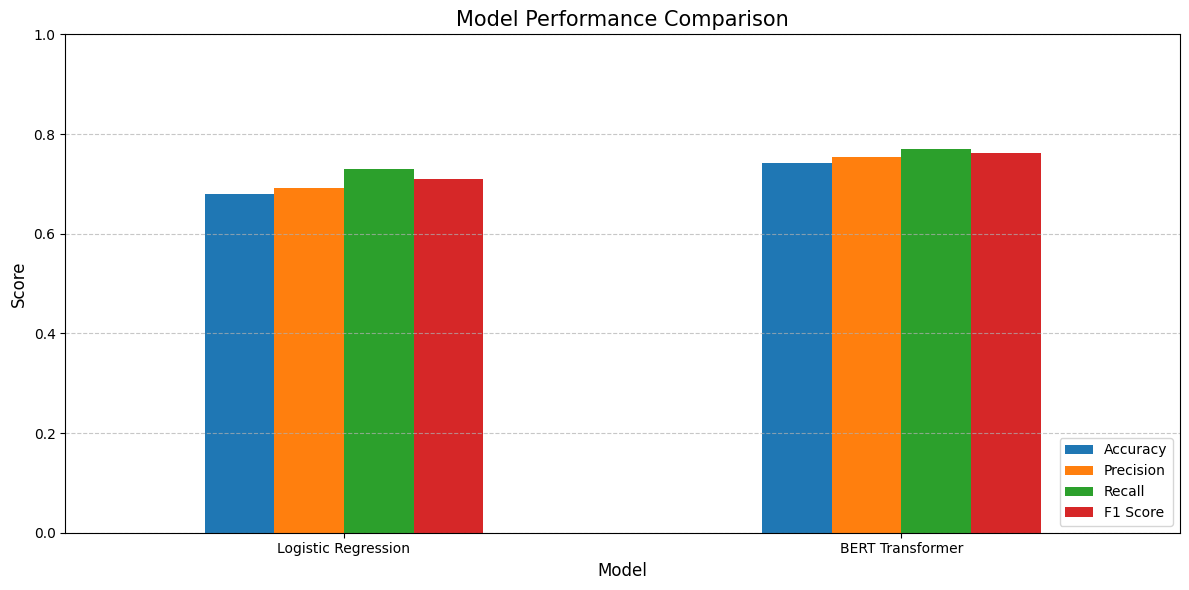

In [6]:
# Compare both models
print("\n=== Model Comparison ===")
metrics = {
    'Accuracy': [accuracy_score(y_test, logistic_preds), accuracy_score(true_labels, transformer_preds)],
    'Precision': [precision_score(y_test, logistic_preds), precision_score(true_labels, transformer_preds)],
    'Recall': [recall_score(y_test, logistic_preds), recall_score(true_labels, transformer_preds)],
    'F1 Score': [f1_score(y_test, logistic_preds), f1_score(true_labels, transformer_preds)]
}

comparison_df = pd.DataFrame(metrics, index=['Logistic Regression', 'BERT Transformer'])
print(comparison_df)

# Visualize comparison
plt.figure(figsize=(12, 6))
comparison_df.plot(kind='bar', rot=0, figsize=(12, 6))
plt.title('Model Performance Comparison', fontsize=15)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()